<a href="https://colab.research.google.com/github/banshee0716/Financial-Big-Data-Analysis/blob/master/%E9%87%91%E8%9E%8D%E6%95%B8%E6%93%9A%E5%88%86%E6%9E%90W6_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.均值回歸策略
*   假設：資產價格會回歸其歷史平均值，隨市場波動動態調整參數。
*   策略邏輯：

  * 當價格低於20日SMA的2個標準差且布林帶下軌時，視為超賣，觸發買入信號。
  * 當價格高於20日SMA的2個標準差且布林帶上軌時，視為超買，觸發賣出信號。
  * 動態調整SMA期間及標準差根據市場波動情況。

## 2. 動量策略
* 假設：資產價格在趨勢中持續運行。
* 策略邏輯：
 * RSI與MACD結合：
   * 當RSI超過70且MACD快線下穿慢線，觸發賣出信號。
   * 當RSI低於30且MACD快線上穿慢線，觸發買入信號。
 * 移動平均線交叉：
   * 當50日SMA突破200日SMA時，觸發黃金交叉買入信號。
   * 當50日SMA跌破200日SMA時，觸發死亡交叉賣出信號。

## 3. 風險管理與資本配置
* 策略邏輯：
  * 最大損失限制：每筆交易損失不超過資本的2%。
  * 止盈機制：當回報率達到10%時平倉。
  * 資本配置：根據Kelly Criterion計算最佳資金分配，並根據市場波動保守調整分配比例。
  
## 4. 多資產組合與風險對沖
* 策略邏輯：
  * 在股票、商品和外匯市場中同時運用策略，實現分散投資。
 *  當進行高風險交易時，利用期權對沖市場波動風險。
* 回測設計與指標
  * 數據選擇：不同市場階段的歷史數據（牛市、熊市、震盪市）。
* 指標：
  * 回報率、最大回撤。
  * Sharpe比率、Sortino比率、Calmar比率。
  * 滾動回測和隨機測試，確保策略的穩健性。

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [ ]:
class QuantStrategy:
    def __init__(self, symbol, start_date, end_date, initial_capital=100000):
        self.symbol = symbol
        self.start_date = start_date
        self.end_date = end_date
        self.initial_capital = initial_capital
        self.data = self.fetch_data()
        self.positions = pd.DataFrame(index=self.data.index).fillna(0.0)
        self.portfolio = self.positions.copy()

    def fetch_data(self):
        data = yf.download(self.symbol, start=self.start_date, end=self.end_date)
        return data

    def calculate_indicators(self):
        # 計算技術指標
        self.data['SMA20'] = self.data['Close'].rolling(window=20).mean()
        self.data['SMA50'] = self.data['Close'].rolling(window=50).mean()
        self.data['SMA200'] = self.data['Close'].rolling(window=200).mean()
        self.data['STD20'] = self.data['Close'].rolling(window=20).std()

        # 布林帶
        self.data['UpperBB'] = self.data['SMA20'] + (self.data['STD20'] * 2)
        self.data['LowerBB'] = self.data['SMA20'] - (self.data['STD20'] * 2)

        # RSI
        delta = self.data['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        self.data['RSI'] = 100 - (100 / (1 + rs))

        # MACD
        exp1 = self.data['Close'].ewm(span=12, adjust=False).mean()
        exp2 = self.data['Close'].ewm(span=26, adjust=False).mean()
        self.data['MACD'] = exp1 - exp2
        self.data['Signal'] = self.data['MACD'].ewm(span=9, adjust=False).mean()

    def generate_signals(self):
        # 均值回歸信號
        self.data['MR_Signal'] = np.where((self.data['Close'] < self.data['LowerBB']) &
                                          (self.data['Close'] < self.data['SMA20'] - 2*self.data['STD20']), 1, 0)
        self.data['MR_Signal'] = np.where((self.data['Close'] > self.data['UpperBB']) &
                                          (self.data['Close'] > self.data['SMA20'] + 2*self.data['STD20']), -1, self.data['MR_Signal'])

        # 動量信號 - RSI & MACD
        self.data['Mom_Signal'] = np.where((self.data['RSI'] < 30) & (self.data['MACD'] > self.data['Signal']), 1, 0)
        self.data['Mom_Signal'] = np.where((self.data['RSI'] > 70) & (self.data['MACD'] < self.data['Signal']), -1, self.data['Mom_Signal'])

        # 動量信號 - 移動平均線交叉
        self.data['MA_Signal'] = np.where(self.data['SMA50'] > self.data['SMA200'], 1, 0)
        self.data['MA_Signal'] = np.where(self.data['SMA50'] < self.data['SMA200'], -1, self.data['MA_Signal'])

        # 綜合信號
        self.data['Signal'] = self.data['MR_Signal'] + self.data['Mom_Signal'] + self.data['MA_Signal']
        self.data['Signal'] = np.sign(self.data['Signal'])  # 轉換為 -1, 0, 1

    def kelly_criterion(self, window=252):
        returns = self.data['Close'].pct_change()
        win_probability = (returns > 0).rolling(window=window).mean().iloc[-1]
        win_loss_ratio = abs(returns[returns > 0].mean() / returns[returns < 0].mean())
        kelly_percentage = win_probability - ((1 - win_probability) / win_loss_ratio)
        return max(0, kelly_percentage)  # 確保不會出現負值

    def backtest(self):
        self.calculate_indicators()
        self.generate_signals()

        self.positions[self.symbol] = self.data['Signal'].shift(1)
        self.portfolio['positions'] = self.positions.multiply(self.data['Close'], axis=0)
        self.portfolio['cash'] = self.initial_capital - (self.positions.diff().multiply(self.data['Close'], axis=0)).cumsum()
        self.portfolio['total'] = self.portfolio['positions'] + self.portfolio['cash']
        self.portfolio['returns'] = self.portfolio['total'].pct_change()

        # 應用止損和止盈
        daily_return = self.portfolio['returns']
        cumulative_return = (1 + daily_return).cumprod() - 1
        self.portfolio['Signal'] = self.data['Signal']
        self.portfolio.loc[cumulative_return <= -0.02, 'Signal'] = 0  # 止損：2%
        self.portfolio.loc[cumulative_return >= 0.10, 'Signal'] = 0  # 止盈：10%

        # 應用Kelly準則
        kelly_pct = self.kelly_criterion()
        self.portfolio['positions'] *= kelly_pct

        # 計算績效指標
        total_return = (self.portfolio['total'].iloc[-1] / self.initial_capital) - 1
        sharpe_ratio = np.sqrt(252) * self.portfolio['returns'].mean() / self.portfolio['returns'].std()
        max_drawdown = (self.portfolio['total'] / self.portfolio['total'].cummax() - 1).min()

        print(f"總回報率: {total_return:.2%}")
        print(f"Sharpe比率: {sharpe_ratio:.2f}")
        print(f"最大回撤: {max_drawdown:.2%}")

        # 繪製權益曲線
        self.portfolio['total'].plot(figsize=(10, 6))
        plt.title('strategic equity curve')
        plt.xlabel('date')
        plt.ylabel('portfolio value')
        plt.show()

    def plot_equity_curve(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.portfolio['total'], label='Portfolio Value')
        plt.title('Strategy Equity Curve')
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_drawdown(self):
        drawdown = (self.portfolio['total'] / self.portfolio['total'].cummax() - 1)
        plt.figure(figsize=(12, 6))
        plt.fill_between(drawdown.index, drawdown.values, alpha=0.3)
        plt.title('Portfolio Drawdown')
        plt.xlabel('Date')
        plt.ylabel('Drawdown')
        plt.grid(True)
        plt.show()

    def plot_returns_distribution(self):
        returns = self.portfolio['returns'].dropna()
        plt.figure(figsize=(12, 6))
        sns.histplot(returns, kde=True)
        plt.title('Returns Distribution')
        plt.xlabel('Daily Returns')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

    def plot_indicators(self):
        fig, axs = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

        # 價格和均線
        axs[0].plot(self.data.index, self.data['Close'], label='Close Price')
        axs[0].plot(self.data.index, self.data['SMA20'], label='SMA20')
        axs[0].plot(self.data.index, self.data['SMA50'], label='SMA50')
        axs[0].plot(self.data.index, self.data['SMA200'], label='SMA200')
        axs[0].set_title('Price and Moving Averages')
        axs[0].legend()
        axs[0].grid(True)

        # RSI
        axs[1].plot(self.data.index, self.data['RSI'], label='RSI')
        axs[1].axhline(y=30, color='r', linestyle='--')
        axs[1].axhline(y=70, color='r', linestyle='--')
        axs[1].set_title('Relative Strength Index (RSI)')
        axs[1].set_ylim(0, 100)
        axs[1].legend()
        axs[1].grid(True)

        # MACD
        axs[2].plot(self.data.index, self.data['MACD'], label='MACD')
        axs[2].plot(self.data.index, self.data['Signal'], label='Signal Line')
        axs[2].bar(self.data.index, self.data['MACD'] - self.data['Signal'], label='MACD Histogram')
        axs[2].set_title('Moving Average Convergence Divergence (MACD)')
        axs[2].legend()
        axs[2].grid(True)

        plt.tight_layout()
        plt.show()

    def visualize_strategy(self):
        self.plot_equity_curve()
        self.plot_drawdown()
        self.plot_returns_distribution()
        self.plot_indicators()


[*********************100%***********************]  1 of 1 completed


總回報率: 1.35%
Sharpe比率: 0.21
最大回撤: -1.38%


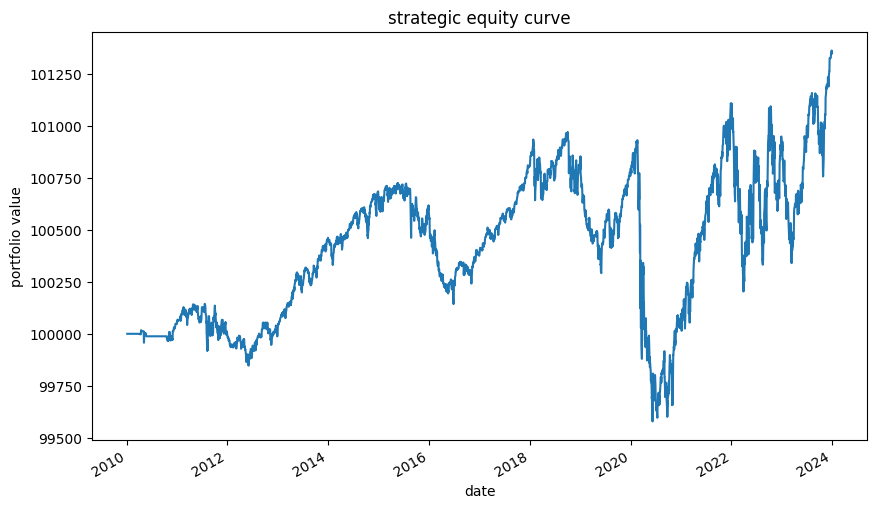

In [ ]:
symbol = "^GSPC"  # S&P 500 指數
start_date = "2010-01-01"
end_date = "2023-12-31"

strategy = QuantStrategy(symbol, start_date, end_date)
strategy.backtest()

In [ ]:
strategy.visualize_strategy()